In [1]:
import os
import torch
import torchvision
import numpy as np
#import tarfile
import torch.nn as nn
import torch.nn.functional as F
#from torchvision.datasets.utils import download_url
#from torchvision.datasets import CIFAR100
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from PIL import Image, ImageEnhance
import nibabel as nib
import cv2
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
file = '.\ISLES\TRAINING\case_1\SMIR.Brain.XX.O.CT_Tmax.345567\SMIR.Brain.XX.O.CT_Tmax.345567.nii'
mask = './ISLES/TRAINING/case_3/SMIR.Brain.XX.O.OT.345580/SMIR.Brain.XX.O.OT.345580.nii'

In [3]:
img = nib.load(file)
mask = nib.load(mask)

In [4]:
img.shape
mask.shape

print(img)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (256, 256, 8)
affine: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 256 256   8   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.        0.976562  0.976562  5.0003    1.        1.        1.
  1.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : al

In [5]:
def cbControl(section):
    alpha = 0.5 # Simple contrast control
    beta = 0.3    # Simple brightness control

    for y in range(section.shape[0]):
        for x in range(section.shape[1]):
                section[y,x] = np.clip(alpha*section[y,x] + beta, 0, 255)
    return section
    

In [5]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept

    return hu_image

In [7]:
H_min = -50
H_max = 1000
H_range = H_max - H_min

def normalizeImageIntensityRange(img):
    img[img < H_min] = H_min
    img[img > H_max] = H_max
    return (img - H_min) / H_range

In [6]:
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

(256, 256, 8)
(256, 256)
0.0 39.0


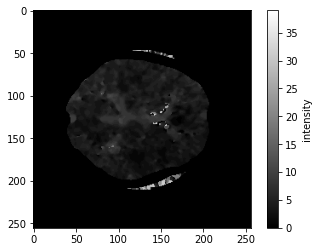

In [10]:
img_data = img.get_fdata()
mask_data = mask.get_fdata()
print(img_data.shape)

section = img_data[:,:,5]
mask_section = mask_data[:,:,7]
print(section.shape)

section.shape

min=np.min(section)        # result=-23.0
max=np.max(section)        # result=2213.0
print(min,max)

#nImg = transform_to_hu(img,section)
nImg = window_image(section,-100,100)



#plt.imshow(nImg, cmap='gray')
plt.imshow(nImg,cmap='gray', alpha=1)
#plt.xlabel('First axis')
#plt.ylabel('Second axis')
plt.colorbar(label='intensity')
plt.show()

In [26]:
# Converting to tensor
entire_scan = img.get_fdata()
section_data = torch.from_numpy(entire_scan)

In [28]:
section_data.shape[1]

256